### Medium story link: 
https://medium.com/@vally.selvarasa/airbnb-in-france-lyon-vs-bordeaux-616315f8d2ec

#### We use three main files for each city from AirBnB data :
#### - Calendar data has pricing and availability over time that can be very useful in analyzing changes in these factors throughout the year. We could look into the means for both cities over time to generate insights and comparisons.
#### - Listings data gives us information like the review scores rating, number of bedrooms, location information, listing price... 
#### - Reviews data

#### In order to get a better understanding of the data, let's take a look at some of the characteristics of the dataset.

In [11]:
#First, let's read in the data and necessary libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from langdetect import detect
from collections import Counter
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.metrics import r2_score
%matplotlib inline
df_Lyon = pd.read_csv('data/listings_Lyon.csv',low_memory=False)
df_Bordeaux = pd.read_csv('data/listings_Bordeaux.csv',low_memory=False)
review_Lyon = pd.read_csv('data/reviews_Lyon.csv',parse_dates=['date'])
review_Bordeaux = pd.read_csv('data/reviews_Bordeaux.csv',parse_dates=['date'])
calendar_Lyon = pd.read_csv('data/calendar_Lyon.csv',parse_dates=['date'])
calendar_Bordeaux = pd.read_csv('data/calendar_Bordeaux.csv',parse_dates=['date'])
df_Lyon.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,30187,https://www.airbnb.com/rooms/30187,20191126081812,2019-11-26,Le Petit Tramassac - Old town Lyon,NaN,Le Petit Tramassac welcome you in the heart of...,Le Petit Tramassac welcome you in the heart of...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,7,7,0,0,0.28
1,56766,https://www.airbnb.com/rooms/56766,20191126081812,2019-11-26,Amazing duplex-terrace in old Lyon,Beautifull duplex terrace on Lyon's roofs ! Co...,We offer a delightful large duplex in the very...,Beautifull duplex terrace on Lyon's roofs ! Co...,none,"l'ambiance générale, la magnifique architectur...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.50
2,71455,https://www.airbnb.com/rooms/71455,20191126081812,2019-11-26,La Loge des Avocats - Vieux Lyon,La Loge des Avocats est un appartement meublé ...,La Loge des Avocats est un appartement meublé ...,La Loge des Avocats est un appartement meublé ...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.15
3,77104,https://www.airbnb.com/rooms/77104,20191126081812,2019-11-26,Nice Flat in the center of Lyon,NaN,"En plein coeur de Lyon, sur la Presqu'ile. A 5...","En plein coeur de Lyon, sur la Presqu'ile. A 5...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.40
4,134539,https://www.airbnb.com/rooms/134539,20191126081812,2019-11-26,"Centre of old town,home sweet home",Ideal situation and cosy..In the center of the...,sorry for my english :) it's a nice flat in t...,Ideal situation and cosy..In the center of the...,none,Il est plus que charment ! C'est le plus beau ...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,3.35


In [13]:
review_Lyon.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

## Reviews data

#### We try to detect the language of each comment

In [2]:
a=[]
to_drop=[]
for k,i in enumerate(review_Lyon.comments):
    try:
        a.append(detect(i))
    except:
        a.append(i)
        to_drop.append(k)
review_Lyon["language"] = a
review_Lyon = review_Lyon.drop(to_drop) # Drop the rows when we couldn't detect anything
review_Lyon = review_Lyon.reset_index(drop=True) # reset index
review_Lyon.to_csv("data/reviews_Lyon_2.csv",index=False)

In [3]:
a=[]
to_drop=[]
for k,i in enumerate(review_Bordeaux.comments):
    try:
        a.append(detect(i))
    except:
        a.append(i)
        to_drop.append(k)
review_Bordeaux["language"] = a
review_Bordeaux = review_Bordeaux.drop(to_drop)
review_Bordeaux = review_Bordeaux.reset_index(drop=True)
review_Bordeaux.to_csv("data/reviews_Bordeaux_2.csv",index=False)

#### We look at the proportion of language for each city:

In [4]:
(review_Lyon.language.value_counts()/review_Lyon.language.count())[0:5] 

fr    0.664819
en    0.275809
de    0.012832
es    0.012375
it    0.008163
Name: language, dtype: float64

In [5]:
(review_Bordeaux.language.value_counts()/review_Bordeaux.language.count())[0:5]

fr    0.645608
en    0.280458
es    0.027831
de    0.012972
it    0.009564
Name: language, dtype: float64

## Calendar data: Availability and Price trough time

In [6]:
# Clean up the data
calendar_Lyon['price'] = calendar_Lyon['price'].apply(lambda x: float(x.replace("$","").replace(",","")) if pd.notna(x) else x)
calendar_Bordeaux['price'] = calendar_Bordeaux['price'].apply(lambda x: float(x.replace("$","").replace(",","")) if pd.notna(x) else x)
calendar_Lyon['year_day'] = calendar_Lyon['date'].apply(lambda x: x.timetuple().tm_yday)
calendar_Bordeaux['year_day'] =calendar_Bordeaux['date'].apply(lambda x: x.timetuple().tm_yday)
calendar_Lyon['available'] = calendar_Lyon['available'].apply(lambda x: True if x == 't' else False)
calendar_Bordeaux['available'] = calendar_Bordeaux['available'].apply(lambda x: True if x == 't' else False)

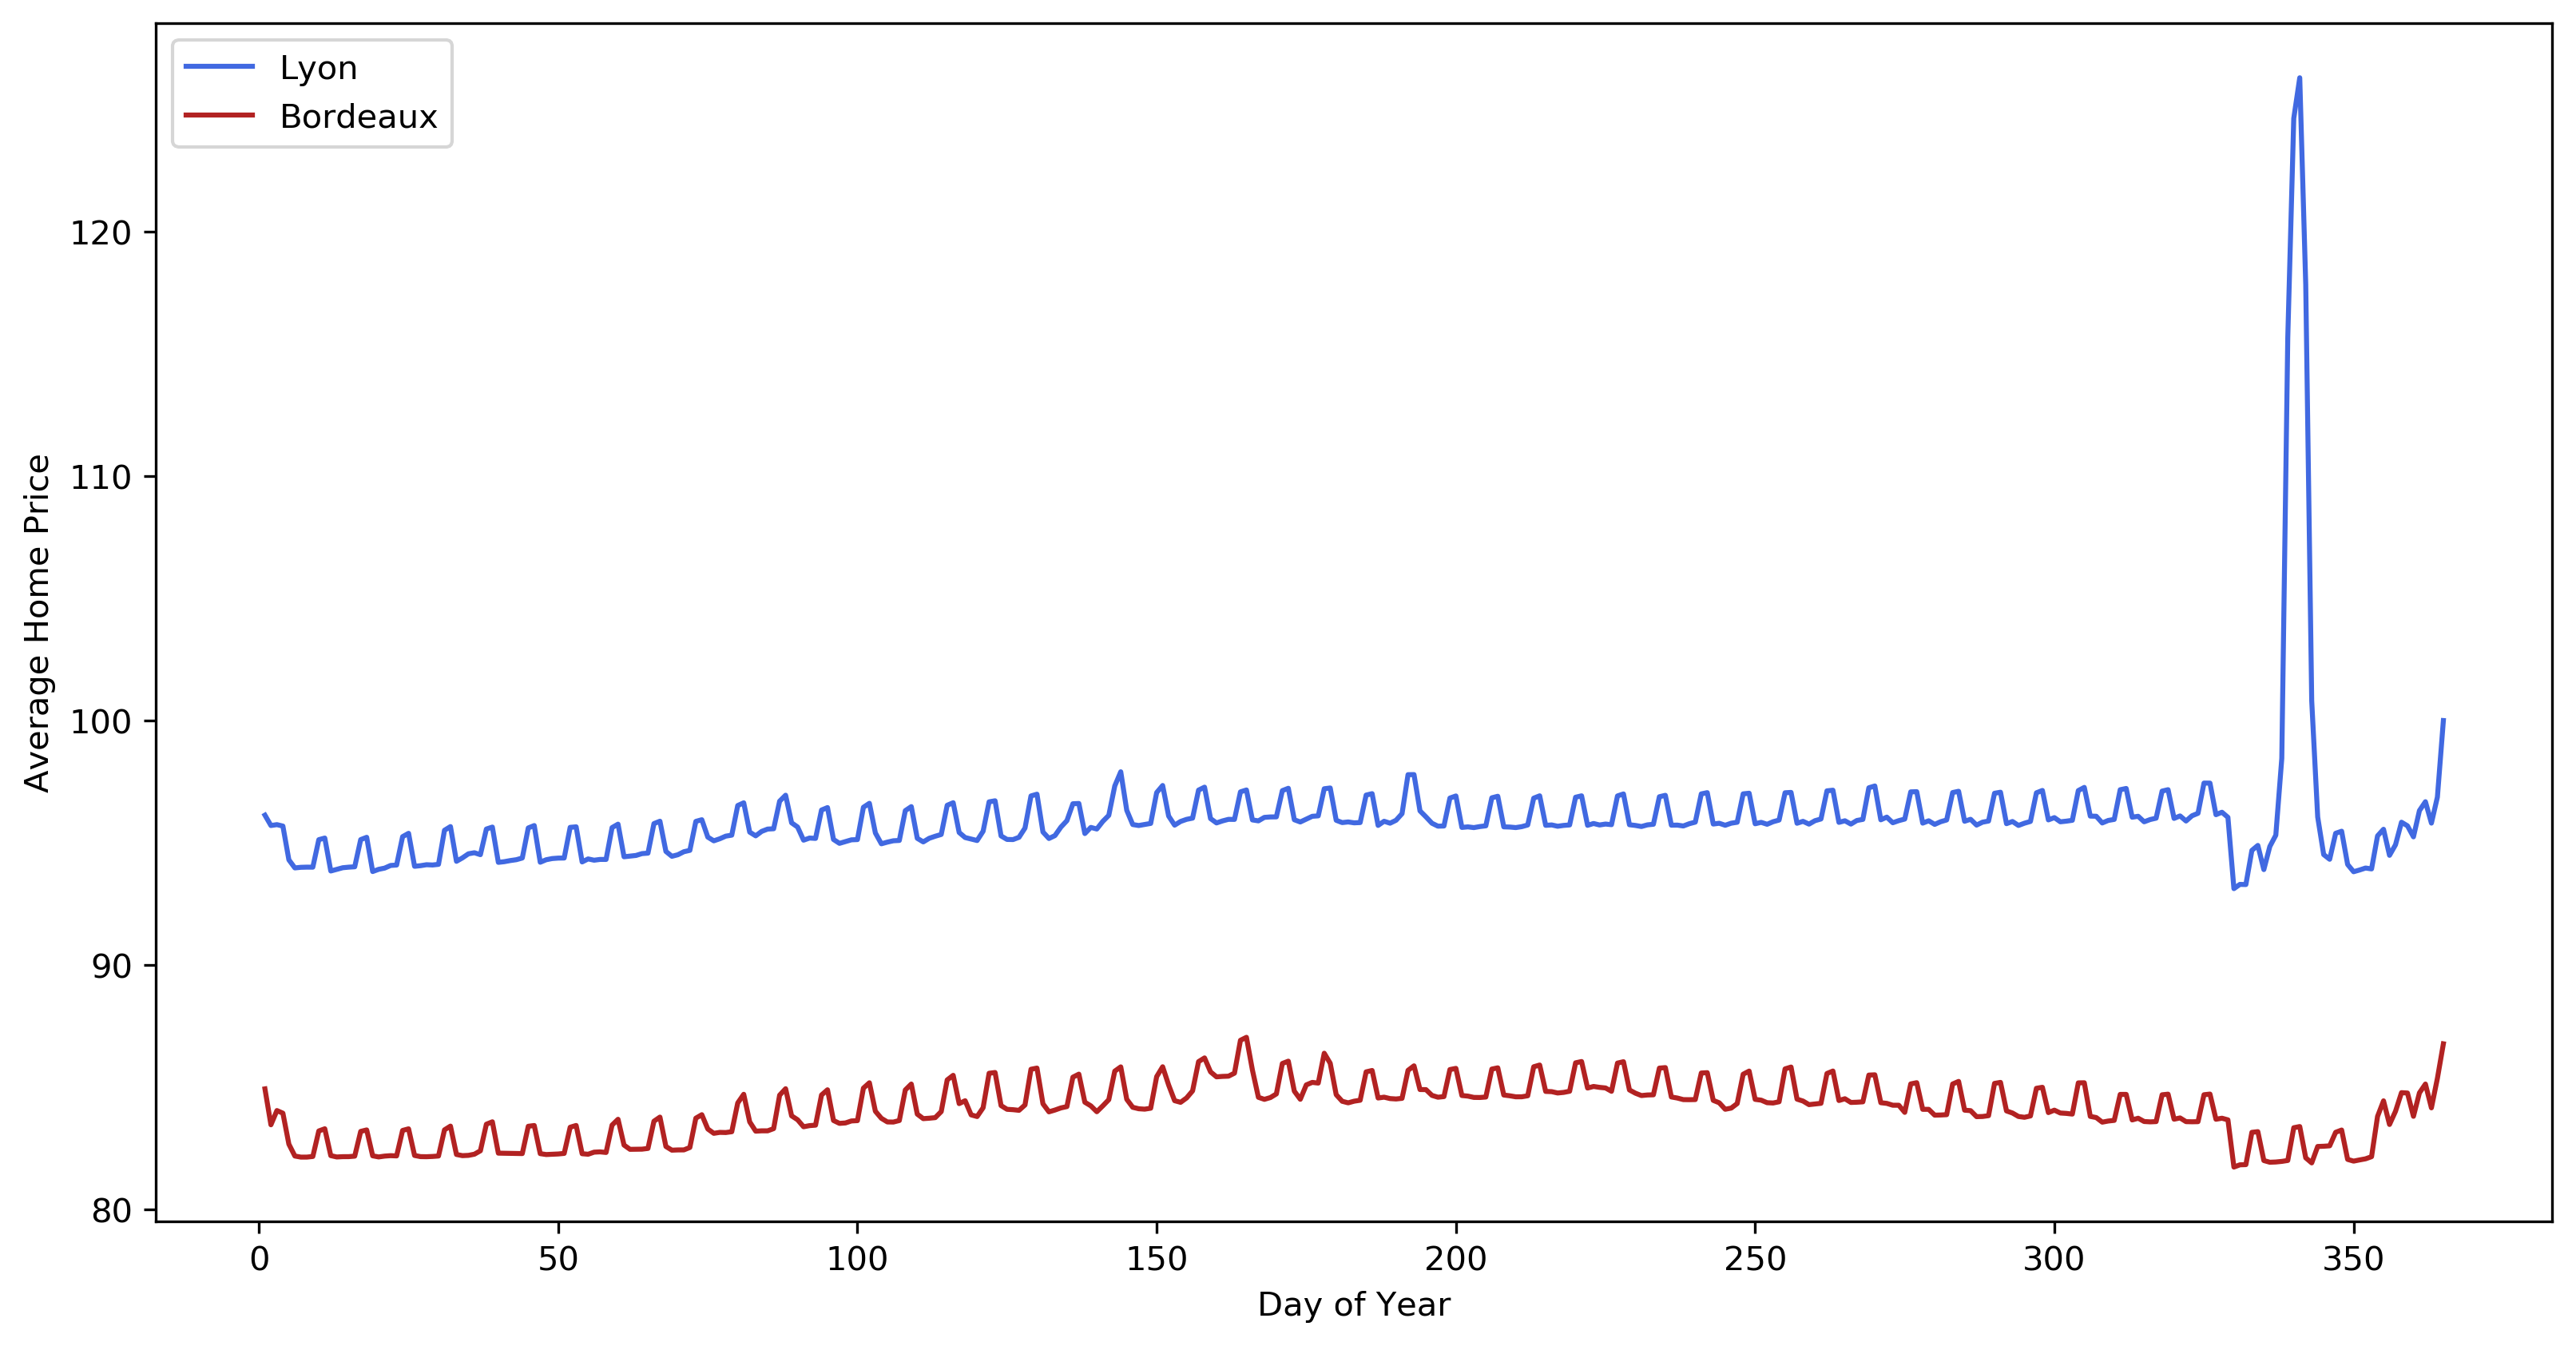

In [7]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(calendar_Lyon.groupby('year_day').mean()['price'],color="royalblue", label='Lyon')
ax.plot(calendar_Bordeaux.groupby('year_day').mean()['price'] ,color="firebrick", label='Bordeaux')
ax.legend()
ax.set_xlabel('Day of Year')
ax.set_ylabel('Average Home Price');

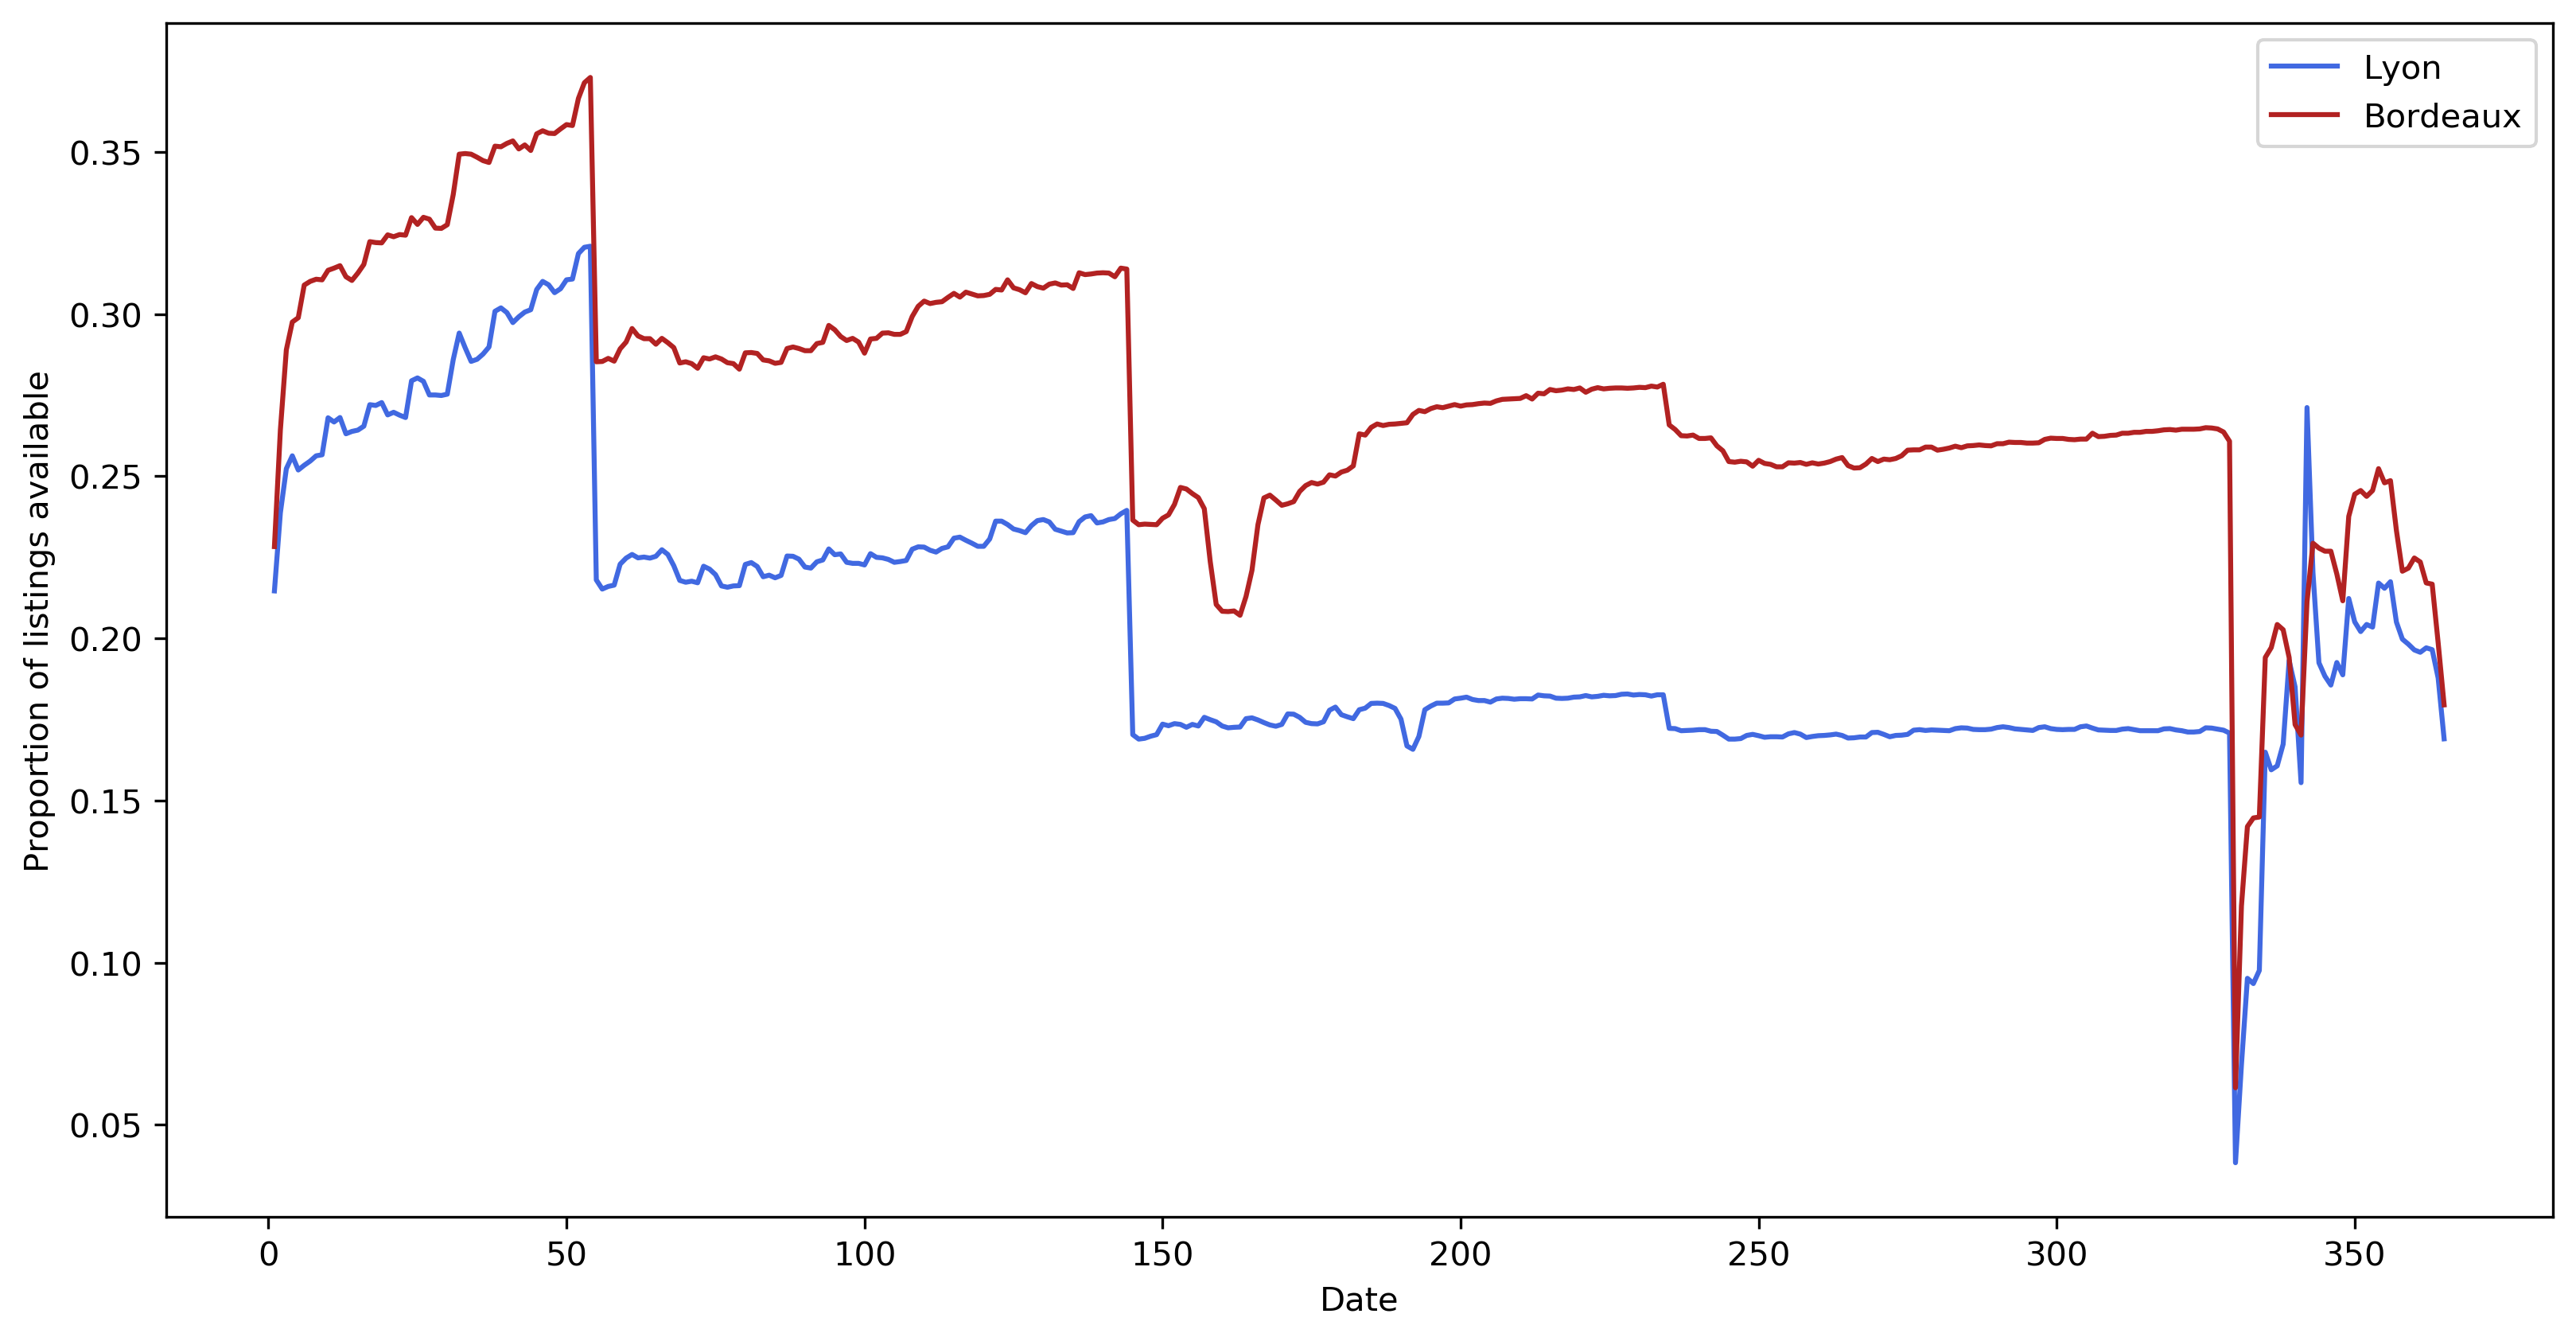

In [8]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(calendar_Lyon.groupby('year_day').mean()["available"],color="royalblue",label="Lyon")
ax.plot(calendar_Bordeaux.groupby('year_day').mean()["available"],color="firebrick",label="Bordeaux")
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of listings available');

## Listing data

In [9]:
print("Lyon :")
print("Number of rows :",df_Lyon.shape[0])
print("Number of columns :",df_Lyon.shape[1])
print("Bordeaux :")
print("Number of rows :",df_Bordeaux.shape[0])
print("Number of columns :",df_Bordeaux.shape[1])

Lyon :
Number of rows : 12364
Number of columns : 106
Bordeaux :
Number of rows : 10529
Number of columns : 106


In [10]:
print("Mean number of homes per host: ")
print("For Lyon: ",df_Lyon.groupby("host_id").size().mean())
print("For Bordeaux: ",df_Bordeaux.groupby("host_id").size().mean())

Mean number of homes per host: 
For Lyon:  1.1541118267525436
For Bordeaux:  1.1987931230786748


#### Check for empty rows or columns:

In [11]:
df_Lyon = df_Lyon.dropna(how="all",axis = 1)
df_Lyon = df_Lyon.dropna(how="all",axis = 0)
df_Bordeaux = df_Bordeaux.dropna(how="all",axis = 1)
df_Bordeaux = df_Bordeaux.dropna(how="all",axis = 0)
print("Lyon: ",df_Lyon.shape,"Bordeaux :",df_Bordeaux.shape)

Lyon:  (12364, 101) Bordeaux : (10529, 102)


In [12]:
# Clean up the price column
df_Lyon["price"] = df_Lyon["price"].apply(lambda x: float(x.replace("$","").replace(",","")) if pd.notna(x) else x)
df_Bordeaux["price"] = df_Bordeaux["price"].apply(lambda x: float(x.replace("$","").replace(",","")) if pd.notna(x) else x)

#### Check for columns with unique value. Drop the columns, and print the new shape of the data:

In [13]:
col_unique_value_Lyon = [col for col in df_Lyon.columns if len(df_Lyon[col].value_counts()) == 1]
col_unique_value_Bordeaux = [col for col in df_Bordeaux.columns if len(df_Bordeaux[col].value_counts()) == 1]
df_Lyon = df_Lyon.drop(col_unique_value_Lyon,axis=1)
df_Bordeaux = df_Bordeaux.drop(col_unique_value_Bordeaux,axis=1)
print("Lyon: ",df_Lyon.shape,"Bordeaux :",df_Bordeaux.shape)

Lyon:  (12364, 94) Bordeaux : (10529, 95)


#### A quick look into the variables distribution:

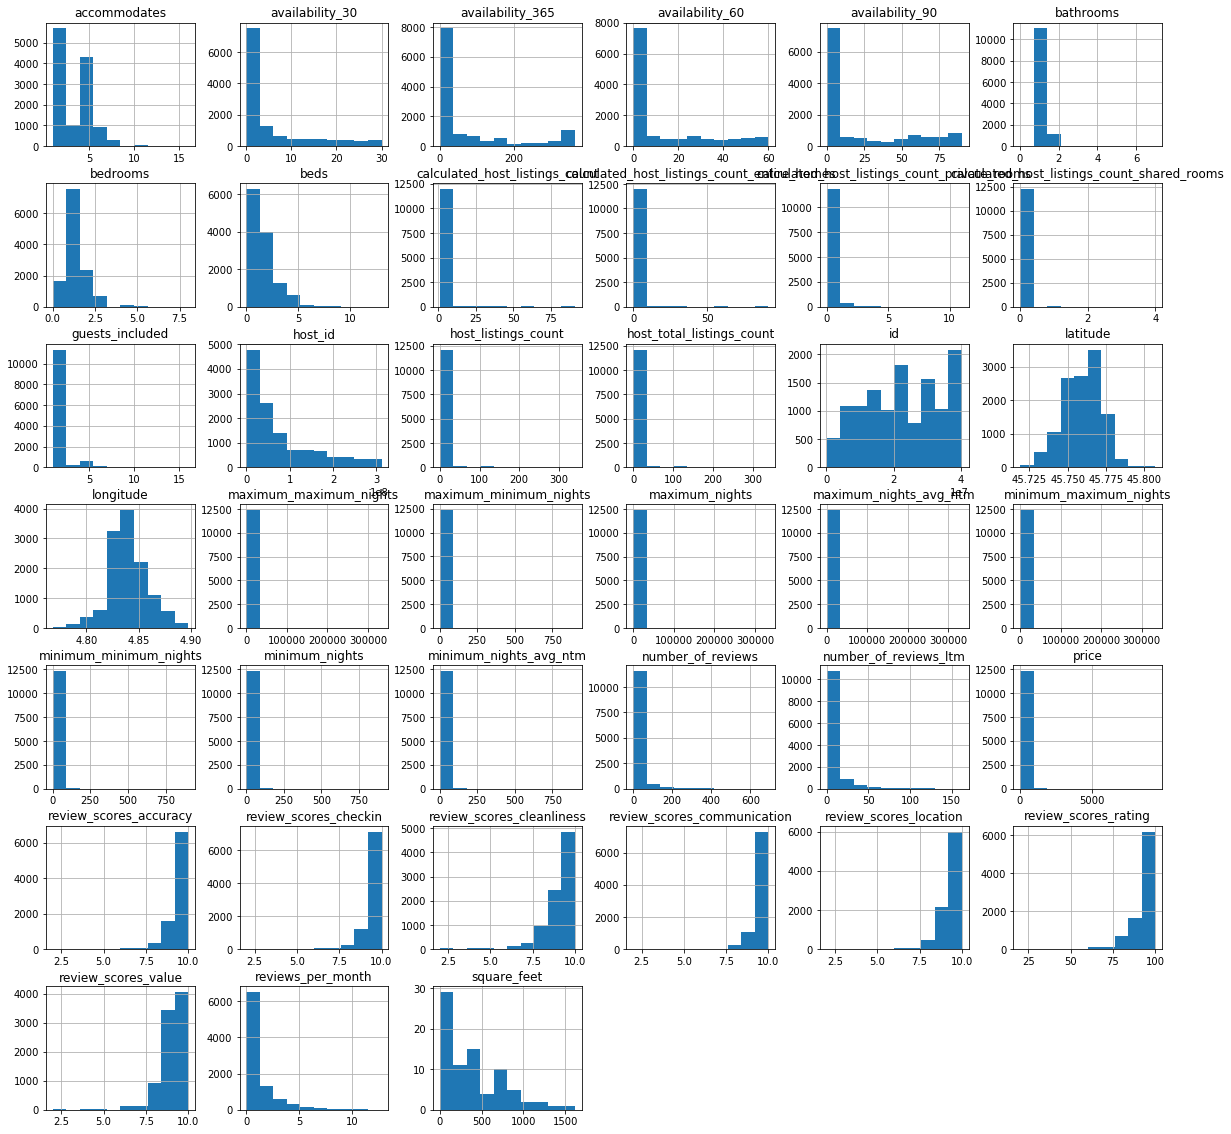

In [14]:
df_Lyon.hist(figsize=(20,20));

In [15]:
print("Bordeaux: ",len(df_Bordeaux[df_Bordeaux.review_scores_rating>=90])/df_Bordeaux.review_scores_rating.count())

Bordeaux:  0.8304611085235212


#### Let's look at the correlation of the review scores with the rating:

In [16]:
df_Lyon_review =  df_Lyon[["review_scores_accuracy",
"review_scores_cleanliness",
"review_scores_checkin",
"review_scores_communication",
"review_scores_location",
"review_scores_value","review_scores_rating"]]

In [17]:
df_Lyon_review.corr()["review_scores_rating"]

review_scores_accuracy         0.626287
review_scores_cleanliness      0.701685
review_scores_checkin          0.560493
review_scores_communication    0.576187
review_scores_location         0.401144
review_scores_value            0.703050
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64

#### Some numbers:

In [18]:
print("Purcentage of listing with a rating score > 90")
print("Lyon: ",len(df_Lyon[df_Lyon.review_scores_rating>=90])/df_Lyon.review_scores_rating.count())
print("Bordeaux: ",len(df_Bordeaux[df_Bordeaux.review_scores_rating>=90])/df_Bordeaux.review_scores_rating.count())

Purcentage of listing with a rating score > 90
Lyon:  0.7985389795685424
Bordeaux:  0.8304611085235212


In [19]:
print("Mean price for listings with a review score between 2 and 6:")
print("Lyon :",df_Lyon.groupby("review_scores_value")['price'].mean()[2:6].mean())
print("Bordeaux :",df_Bordeaux.groupby("review_scores_value")['price'].mean()[2:6].mean())

Mean price for listings with a review score between 2 and 6:
Lyon : 110.09192172726075
Bordeaux : 67.17493781094528


In [20]:
print("Mean price for listings with a review score >= 9:")
print("Lyon :",df_Lyon.groupby("review_scores_value")['price'].mean()[9:].mean())
print("Bordeaux :",df_Bordeaux.groupby("review_scores_value")['price'].mean()[9:].mean())

Mean price for listings with a review score >= 9:
Lyon : 77.35571640170554
Bordeaux : 80.31614918171886


In [21]:
df_Lyon[df_Lyon["host_is_superhost"]=="t"]["host_is_superhost"].count()/df_Lyon["host_is_superhost"].count()

0.12334088701845257

In [22]:
df_Bordeaux[df_Bordeaux["host_is_superhost"]=="t"]["host_is_superhost"].count()/df_Bordeaux["host_is_superhost"].count()

0.18451306413301663

In [23]:
print("Mean of number of reviews for superhosts:")
print("Lyon :",df_Lyon[df_Lyon["host_is_superhost"]=="t"]["number_of_reviews"].mean())
print("Bordeaux :",df_Bordeaux[df_Bordeaux["host_is_superhost"]=="t"]["number_of_reviews"].mean())

Mean of number of reviews for superhosts:
Lyon : 57.444225721784775
Bordeaux : 50.99073120494336


In [24]:
print("Mean of number of reviews for other superhosts:")
print("Lyon :",df_Lyon[df_Lyon["host_is_superhost"]=="f"]["number_of_reviews"].mean())
print("Bordeaux :",df_Bordeaux[df_Bordeaux["host_is_superhost"]=="f"]["number_of_reviews"].mean())

Mean of number of reviews for other superhosts:
Lyon : 11.960856720827179
Bordeaux : 14.829430269136665


In [25]:
print("Mean of available days for superhosts:")
print("Lyon :",df_Lyon[df_Lyon["host_is_superhost"]=="t"]["availability_365"].mean())
print("Bordeaux :",df_Bordeaux[df_Bordeaux["host_is_superhost"]=="t"]["availability_365"].mean())

Mean of available days for superhosts:
Lyon : 128.76968503937007
Bordeaux : 141.18898043254376


In [26]:
print("Mean of available days for other hosts:")
print("Lyon :",df_Lyon[df_Lyon["host_is_superhost"]=="f"]["availability_365"].mean())
print("Bordeaux :",df_Bordeaux[df_Bordeaux["host_is_superhost"]=="f"]["availability_365"].mean())

Mean of available days for other hosts:
Lyon : 65.64992614475628
Bordeaux : 88.79704066177327


In [27]:
print("Mean of available days for other hosts:")
print("Lyon :",df_Lyon[df_Lyon["host_is_superhost"]=="t"]["review_scores_value"].mean())
print("Bordeaux :",df_Bordeaux[df_Bordeaux["host_is_superhost"]=="t"]["review_scores_value"].mean())

Mean of available days for other hosts:
Lyon : 9.608080808080809
Bordeaux : 9.680703624733475


### Categorical Variables

In [28]:
print("Lyon, Number of Categorical Variables :",len(df_Lyon.select_dtypes(include = "object").columns))
print("Bordaux, Number of Categorical Variables :",len(df_Bordeaux.select_dtypes(include = "object").columns))

Lyon, Number of Categorical Variables : 55
Bordaux, Number of Categorical Variables : 56


#### Names of these variables:

In [29]:
df_Bordeaux.select_dtypes(include = "object").columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',
   

#### We drop all the text data, we keep two variables indicating the location and we drop all the variables with a price:

In [30]:
df_Lyon = df_Lyon.drop(['last_scraped',"access",'interaction','house_rules',"listing_url",'name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes',"picture_url",'market','calendar_last_scraped','jurisdiction_names',
       'host_url', 'host_name','host_location','host_about',"host_thumbnail_url",'host_picture_url','host_neighbourhood','street','neighbourhood','city',
       'state', 'smart_location','weekly_price', 'monthly_price','security_deposit', 'cleaning_fee','extra_people','calendar_updated','first_review'],axis = 1)

In [31]:
df_Bordeaux= df_Bordeaux.drop(['last_scraped',"access",'interaction','house_rules',"listing_url",'name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes',"picture_url",'market','calendar_last_scraped','jurisdiction_names', "neighbourhood_group_cleansed",
       'host_url', 'host_name','host_location','host_about',"host_thumbnail_url",'host_picture_url','host_neighbourhood','street','neighbourhood','city',
       'state', 'smart_location','weekly_price', 'monthly_price','security_deposit', 'cleaning_fee','extra_people','calendar_updated','first_review'],axis = 1)

In [32]:
print("Lyon: ",df_Lyon.shape,"Bordeaux :",df_Bordeaux.shape)

Lyon:  (12364, 60) Bordeaux : (10529, 60)


#### The column amenities can be cleaned:

In [33]:
df_Lyon["amenities"][12]

'{Wifi,"Air conditioning",Kitchen,Elevator,"Free street parking",Heating,Washer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,"Lock on bedroom door","Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50",Bathtub,"Children’s books and toys","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Garden or backyard","Luggage dropoff allowed","Host greets you"}'

In [34]:
amenities_Lyon = df_Lyon["amenities"].apply(lambda x: x.replace('"',"").replace("{","").replace("}","").split(","))
amenities_Bordeaux = df_Bordeaux["amenities"].apply(lambda x: x.replace('"',"").replace("{","").replace("}","").split(","))
am_Lyon = []
am_Bordeaux=[]
for i in amenities_Lyon:
    am_Lyon+=i
for i in amenities_Bordeaux:
    am_Bordeaux+=i

In [35]:
amenities_Lyon = pd.DataFrame(list(zip(Counter(am_Lyon).keys(),Counter(am_Lyon).values())), columns=["Name","Count"]).sort_values(by="Count",ascending = False)
amenities_Bordeaux = pd.DataFrame(list(zip(Counter(am_Bordeaux).keys(),Counter(am_Bordeaux).values())), columns=["Name","Count"]).sort_values(by="Count",ascending = False)

In [36]:
amenities_Lyon["Proportion"] = amenities_Lyon.Count/len(df_Lyon)
amenities_Bordeaux["Proportion"] = amenities_Bordeaux.Count/len(df_Bordeaux)

In [37]:
print("Lyon, Number of classes found: ",len(amenities_Lyon))
print("Bordeaux, Number of classes found: ",len(amenities_Bordeaux))

Lyon, Number of classes found:  165
Bordeaux, Number of classes found:  155


#### Proportion of each service (top ten) in the data: 

In [38]:
amenities_Lyon[0:10]

,Name,Count,Proportion
5,Heating,11730,0.948722
4,Kitchen,11723,0.948156
8,Essentials,11424,0.923973
2,Wifi,11299,0.913863
7,Smoke detector,9374,0.758169
6,Washer,9364,0.757360
11,Hair dryer,8184,0.661922
0,TV,8033,0.649709
12,Iron,7614,0.615820
10,Hangers,7566,0.611938


In [39]:
amenities_Bordeaux[0:10]

,Name,Count,Proportion
12,Heating,9849,0.935416
16,Essentials,9764,0.927344
2,Wifi,9652,0.916706
3,Kitchen,9569,0.908823
15,Smoke detector,8126,0.771773
19,Hangers,7851,0.745655
0,TV,7825,0.743185
13,Washer,7617,0.723431
20,Hair dryer,7175,0.681451
21,Iron,7079,0.672334


In [40]:
# Clean up host_response_rate by removing "%"
df_Lyon["host_response_rate"] = df_Lyon["host_response_rate"].apply(lambda x: float(x.replace("%","")) if pd.notna(x) else x)
df_Bordeaux["host_response_rate"] = df_Bordeaux["host_response_rate"].apply(lambda x: float(x.replace("%","")) if pd.notna(x) else x)

In [41]:
# host_since and last_review are a date type:
df_Lyon['host_since']=df_Lyon['host_since'].astype("datetime64")
df_Bordeaux['host_since']=df_Bordeaux['host_since'].astype("datetime64")
df_Lyon['last_review']=df_Lyon['last_review'].astype("datetime64")
df_Bordeaux['last_review']=df_Bordeaux['last_review'].astype("datetime64")

#### Categorical variables with more than 10 classes:

In [42]:
for i in df_Lyon.select_dtypes(include = "object").columns:
    if len(set(df_Lyon[i])) > 10:
        print(i,len(set(df_Lyon[i])))

transit 7440
host_verifications 238
zipcode 35
property_type 24
amenities 11842
license 1773


In [43]:
df_Lyon["host_verifications"][0]

"['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']"

In [44]:
# host_verifications should be cleaned:
host_verifications_Lyon = df_Lyon["host_verifications"].apply(lambda x: x.replace("'","").replace("[","").replace("]","").split(","))
host_verifications_Bordeaux = df_Bordeaux["host_verifications"].apply(lambda x: x.replace("'","").replace("[","").replace("]","").split(","))
hv_Lyon = []
hv_Bordeaux = []
for i in host_verifications_Lyon:
    hv_Lyon+=i
for i in host_verifications_Bordeaux:
    hv_Bordeaux+=i

In [45]:
host_verifications_Lyon=pd.DataFrame(list(zip(Counter(hv_Lyon).keys(),Counter(hv_Lyon).values())), columns=["Name","Count"]).sort_values(by="Count",ascending = False)
host_verifications_Lyon["Proportion"] = host_verifications_Lyon.Count/len(df_Lyon)
host_verifications_Bordeaux=pd.DataFrame(list(zip(Counter(hv_Bordeaux).keys(),Counter(hv_Bordeaux).values())), columns=["Name","Count"]).sort_values(by="Count",ascending = False)
host_verifications_Bordeaux["Proportion"] = host_verifications_Bordeaux.Count/len(df_Bordeaux)

In [46]:
print("Lyon, Number of different host verifications found: ",len(host_verifications_Lyon))
print("Bordeaux, Number of different host verifications found: ",len(host_verifications_Bordeaux))

Lyon, Number of different host verifications found:  22
Bordeaux, Number of different host verifications found:  23


In [47]:
host_verifications_Lyon.head() #Five first classes ranked by the proportion in the data

,Name,Count,Proportion
0,email,11582,0.936752
1,phone,11537,0.933112
3,reviews,8553,0.691766
5,government_id,8337,0.674296
4,jumio,6881,0.556535


In [48]:
host_verifications_Bordeaux.head()

,Name,Count,Proportion
0,email,9835,0.934087
1,phone,9797,0.930478
2,reviews,7267,0.690189
5,government_id,6705,0.636813
4,jumio,5441,0.516763


### Missing Values

In [49]:
df_Lyon.isna().mean()[df_Lyon.isna().mean()>0].sort_values(ascending=False)

square_feet                    0.993530
license                        0.847460
host_response_time             0.471045
host_response_rate             0.471045
transit                        0.376658
review_scores_checkin          0.292462
review_scores_value            0.292300
review_scores_location         0.292300
review_scores_accuracy         0.292300
review_scores_communication    0.291896
review_scores_cleanliness      0.291896
review_scores_rating           0.291411
reviews_per_month              0.268683
last_review                    0.268602
zipcode                        0.010676
beds                           0.003882
bedrooms                       0.002022
bathrooms                      0.000647
host_identity_verified         0.000647
host_has_profile_pic           0.000647
host_total_listings_count      0.000647
host_listings_count            0.000647
host_is_superhost              0.000647
host_since                     0.000647
dtype: float64

In [50]:
df_Bordeaux.isna().mean()[df_Bordeaux.isna().mean()>0].sort_values(ascending=False)

square_feet                    0.992687
license                        0.834932
host_response_time             0.402887
host_response_rate             0.402887
transit                        0.338874
review_scores_checkin          0.185393
review_scores_value            0.185203
review_scores_location         0.185203
review_scores_accuracy         0.185108
review_scores_communication    0.185013
review_scores_cleanliness      0.184728
review_scores_rating           0.184348
reviews_per_month              0.168867
last_review                    0.168867
zipcode                        0.010637
beds                           0.002469
bedrooms                       0.001045
bathrooms                      0.000380
host_identity_verified         0.000380
host_has_profile_pic           0.000380
host_total_listings_count      0.000380
host_listings_count            0.000380
host_is_superhost              0.000380
host_since                     0.000380
dtype: float64

In [51]:
# get dummies for the nan
df_Lyon["square_feet"] = pd.get_dummies(df_Lyon["square_feet"], dummy_na = True, drop_first=True)[np.NaN]
df_Lyon["transit"] = pd.get_dummies(df_Lyon["transit"] , dummy_na = True, drop_first=True)[np.NaN]
df_Lyon["license"] = pd.get_dummies(df_Lyon["license"] , dummy_na = True, drop_first=True)[np.NaN]
df_Bordeaux["square_feet"] = pd.get_dummies(df_Bordeaux["square_feet"], dummy_na = True, drop_first=True)[np.NaN]
df_Bordeaux["transit"] = pd.get_dummies(df_Bordeaux["transit"] , dummy_na = True, drop_first=True)[np.NaN]
df_Bordeaux["license"] = pd.get_dummies(df_Bordeaux["license"] , dummy_na = True, drop_first=True)[np.NaN]

In [52]:
df_Lyon[df_Lyon['host_since'].isna()]

,id,transit,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
623,4415530,0,22919288,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,strict_14_with_grace_period,f,f,1,1,0,0,NaN
905,4677847,0,13529262,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,2,2,0,0,0.30
1320,6625145,0,34675192,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,t,moderate,f,f,1,1,0,0,0.68
1494,7379418,1,38155978,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,1,1,0,0,NaN
1505,7429870,0,38918399,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,1,1,0,0,NaN
2192,9395816,0,48732677,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,1,0,1,0,NaN
5465,21432765,0,13529262,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,2,2,0,0,0.04
11805,40099471,0,309254421,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,moderate,f,f,1,1,0,0,NaN


In [53]:
df_Bordeaux[df_Bordeaux['host_since'].isna()] # A lot of missing values for these rows

,id,transit,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
562,5105591,0,26353691,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,1,0,1,0,0.24
2162,12794737,0,69680100,NaT,NaN,NaN,NaN,NaN,NaN,None,...,0,f,moderate,f,f,1,1,0,0,7.72
8312,34194256,0,143261443,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,t,flexible,f,f,1,1,0,0,0.89
8577,34851095,0,72105613,NaT,NaN,NaN,NaN,NaN,NaN,None,...,1,f,flexible,f,f,1,1,0,0,0.34


In [54]:
df_Lyon = df_Lyon.drop(df_Lyon[df_Lyon['host_since'].isna()].index) # drop the rows where host_since is missing
df_Lyon = df_Lyon.reset_index(drop=True)
df_Bordeaux = df_Bordeaux.drop(df_Bordeaux[df_Bordeaux['host_since'].isna()].index)
df_Bordeaux= df_Bordeaux.reset_index(drop=True)

In [55]:
ID_Lyon = df_Lyon["id"]          # stock the id
df_Lyon = df_Lyon.drop(["id"],axis = 1)   # drop it
ID_Bordeaux = df_Bordeaux["id"]          # stock the id
df_Bordeaux = df_Bordeaux.drop(["id"],axis = 1)   # drop it

#### We transform date type variables into continuous variables

In [56]:
df_Lyon['host_since'] = df_Lyon['host_since'].apply(lambda x: datetime.timestamp(x))
df_Bordeaux['host_since'] = df_Bordeaux['host_since'].apply(lambda x: datetime.timestamp(x))
df_Lyon['last_review'] = df_Lyon['last_review'].apply(lambda x: datetime.timestamp(x) if pd.notna(x) else None)
df_Bordeaux['last_review'] = df_Bordeaux['last_review'].apply(lambda x: datetime.timestamp(x) if pd.notna(x) else None)

In [57]:
df_Lyon['last_review']=df_Lyon['last_review'].astype("float64")
df_Bordeaux['last_review']=df_Bordeaux['last_review'].astype("float64")

#### Impute by mean for continuous variables:

In [58]:
for i in df_Lyon.select_dtypes(include = ["int64","float64"]).columns:
    if df_Lyon[i].isna().sum()!=0:
        df_Lyon[i].fillna(df_Lyon[i].mean(), inplace=True)
for i in df_Bordeaux.select_dtypes(include = ["int64","float64"]).columns:
    if df_Bordeaux[i].isna().sum()!=0:
        df_Bordeaux[i].fillna(df_Bordeaux[i].mean(), inplace=True)

#### Categorical variables with less than 10 classes:

In [59]:
for i in df_Lyon.select_dtypes(include = "object").columns:
    if len(set(df_Lyon[i])) < 10:
        print(i,":",set(df_Lyon[i]))

host_response_time : {nan, 'a few days or more', 'within an hour', 'within a day', 'within a few hours'}
host_is_superhost : {'f', 't'}
host_has_profile_pic : {'f', 't'}
host_identity_verified : {'f', 't'}
neighbourhood_cleansed : {'5e Arrondissement', '8e Arrondissement', '7e Arrondissement', '4e Arrondissement', '9e Arrondissement', '1er Arrondissement', '2e Arrondissement', '6e Arrondissement', '3e Arrondissement'}
is_location_exact : {'f', 't'}
room_type : {'Hotel room', 'Entire home/apt', 'Private room', 'Shared room'}
bed_type : {'Pull-out Sofa', 'Real Bed', 'Futon', 'Airbed', 'Couch'}
instant_bookable : {'f', 't'}
cancellation_policy : {'strict_14_with_grace_period', 'flexible', 'moderate', 'super_strict_30'}
require_guest_profile_picture : {'f', 't'}
require_guest_phone_verification : {'f', 't'}


## Location Analyze

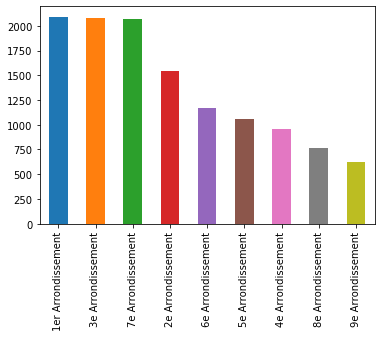

In [60]:
df_Lyon.neighbourhood_cleansed.value_counts().plot(kind='bar');

In [61]:
df_Lyon[df_Lyon["host_is_superhost"] == "t"].groupby("neighbourhood_cleansed").size()/df_Lyon[df_Lyon["host_is_superhost"] == "t"]["host_is_superhost"].count()

neighbourhood_cleansed
1er Arrondissement    0.163386
2e Arrondissement     0.122047
3e Arrondissement     0.169948
4e Arrondissement     0.092520
5e Arrondissement     0.106299
6e Arrondissement     0.097113
7e Arrondissement     0.129265
8e Arrondissement     0.068241
9e Arrondissement     0.051181
dtype: float64

In [62]:
df_Lyon.groupby("neighbourhood_cleansed")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
1er Arrondissement,2093.0,103.518395,89.127850,9.0,50.0,75.0,125.0,1000.0
2e Arrondissement,1547.0,131.065934,262.857963,10.0,53.0,85.0,150.0,7777.0
3e Arrondissement,2079.0,93.017797,221.666377,9.0,41.0,60.0,100.0,9400.0
4e Arrondissement,954.0,92.294549,97.468418,9.0,47.0,68.5,100.0,1500.0
5e Arrondissement,1058.0,92.794896,79.380826,9.0,50.0,70.0,109.0,1035.0
6e Arrondissement,1165.0,94.395708,75.014034,9.0,49.0,70.0,110.0,1001.0
7e Arrondissement,2072.0,83.992761,85.571679,9.0,40.0,60.0,100.0,1600.0
8e Arrondissement,767.0,72.006519,80.069006,12.0,35.0,50.0,80.0,1500.0
9e Arrondissement,621.0,80.666667,96.246441,12.0,39.0,58.0,84.0,1242.0


#### Create a map with 4 categories of price

In [63]:
locationlist_25 = df_Lyon[df_Lyon.price < 45][['latitude', 'longitude']].values.tolist()
locationlist_50_minus= df_Lyon[df_Lyon.price >=45][df_Lyon.price < 65][['latitude', 'longitude']].values.tolist()
locationlist_50_plus = df_Lyon[df_Lyon.price < 110][df_Lyon.price >= 65][['latitude', 'longitude']].values.tolist()
locationlist_75 = df_Lyon[df_Lyon.price >= 110][['latitude', 'longitude']].values.tolist()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
lyon = folium.Map(location=[45.8, 4.8],zoom_start=14)
for point in range(0, len(locationlist_25)):
    folium.CircleMarker(
        locationlist_25[point],
        radius = 5,
        color='g',
        fill_color="green",
        fill=True,
        fill_opacity=0.3, parse_html=True
        ).add_to(lyon)
for point in range(0, len(locationlist_50_minus)):
    folium.CircleMarker(
        locationlist_50_minus[point],
        radius = 5,
        color='y',
        fill_color="yellow",
        fill=True,
        fill_opacity=0.3, parse_html=True
        ).add_to(lyon)
for point in range(0, len(locationlist_50_plus)):
    folium.CircleMarker(
        locationlist_50_plus[point],
        radius = 5,
        color='o',
        fill_color="orange",
        fill=True,
        fill_opacity=0.3, parse_html=True
        ).add_to(lyon)
for point in range(0, len(locationlist_75)):
    folium.CircleMarker(
        locationlist_75[point],
        radius = 5,
        color='r',
        fill_color="red",
        fill=True,
        fill_opacity=0.3,parse_html=True
        ).add_to(lyon)

In [65]:
lyon.save(outfile='Lyon_map.html')

### Is there any linear relationships between some variables and the price ?

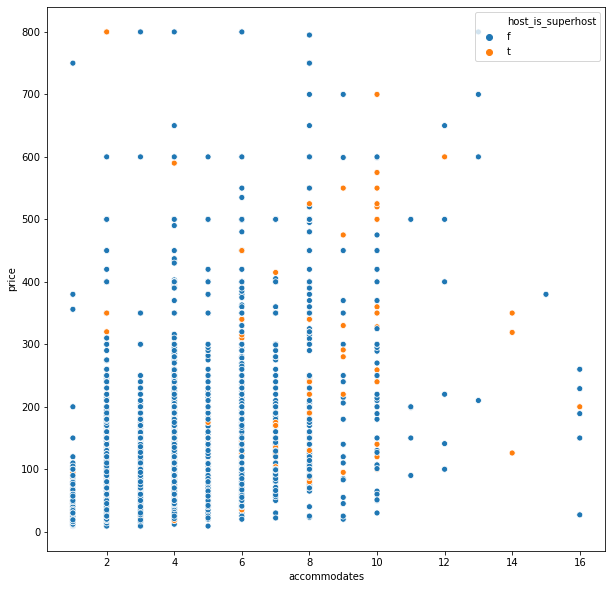

In [66]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="accommodates", y="price",
              hue="host_is_superhost",
              data=df_Lyon[df_Lyon.price < 1000]); # We remove outliers for a better visualization

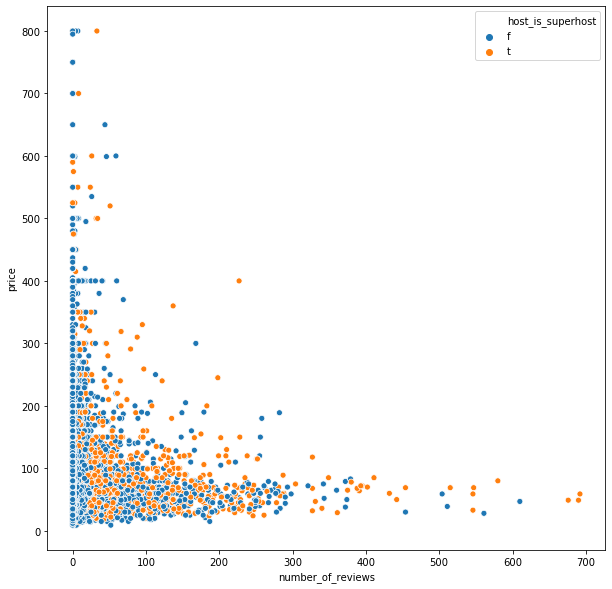

In [67]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="number_of_reviews", y="price",
              hue="host_is_superhost",
              data=df_Lyon[df_Lyon.price < 1000]); # We remove outliers for a better visualization

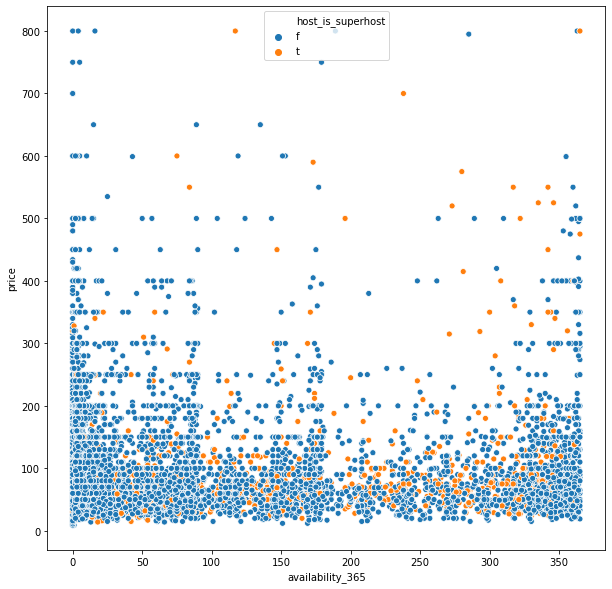

In [68]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="availability_365", y="price",
              hue="host_is_superhost",
              data=df_Lyon[df_Lyon.price < 1000]);

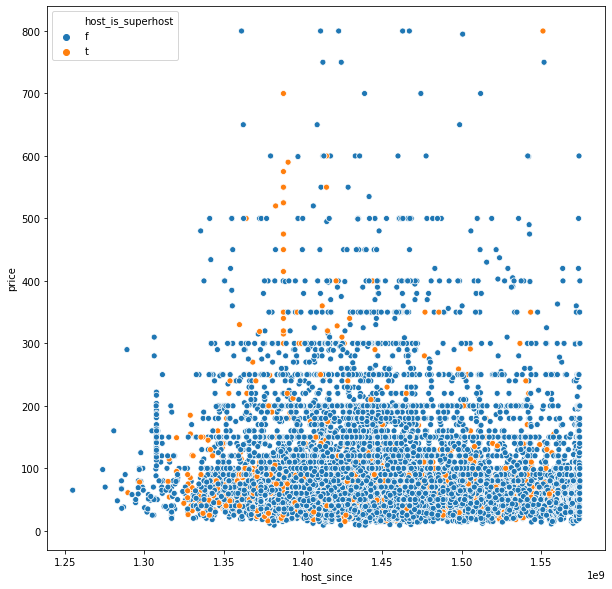

In [69]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="host_since", y="price",
              hue="host_is_superhost",
              data=df_Lyon[df_Lyon.price < 1000]);

There did not seem to be any strong linear relationships between the predictors and the target variable. 

### Dummy Variables

#### The column amenities:

In [70]:
for name in ["Wifi","TV","Laptop friendly workspace","Elevator","Family/kid friendly","Cooking basics"]:
    a = []
    for value in df_Lyon["amenities"]:
        if name in value:
            a.append(1)
        else:
            a.append(0)
    df_Lyon["amenities_"+name.strip()] = a
df_Lyon = df_Lyon.drop(["amenities"],axis=1)

In [71]:
for name in ["Wifi","TV","Laptop friendly workspace","Elevator","Family/kid friendly","Cooking basics"]:
    a = []
    for value in df_Bordeaux["amenities"]:
        if name in value:
            a.append(1)
        else:
            a.append(0)
    df_Bordeaux["amenities_"+name.strip()] = a
df_Bordeaux = df_Bordeaux.drop(["amenities"],axis=1)

In [72]:
a = []
for value in df_Lyon["host_verifications"]:
    if "reviews" in value:
        a.append(1)
    else:
        a.append(0)
df_Lyon["host_verifications_"+"reviews"] = a
df_Lyon = df_Lyon.drop(["host_verifications"],axis=1)
df_Lyon.shape

(12356, 64)

In [73]:
a = []
for value in df_Bordeaux["host_verifications"]:
    if "reviews" in value:
        a.append(1)
    else:
        a.append(0)
df_Bordeaux["host_verifications_"+"reviews"] = a
df_Bordeaux = df_Bordeaux.drop(["host_verifications"],axis=1)
df_Bordeaux.shape

(10525, 64)

In [74]:
for col in df_Lyon.select_dtypes(include="object").columns:
    if df_Lyon[col].isna().sum() == 0:
        dummy_na = False
    else:
        dummy_na = True
    df_Lyon = pd.concat([df_Lyon.drop(col, axis=1), pd.get_dummies(df_Lyon[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
for col in df_Bordeaux.select_dtypes(include="object").columns:
    if df_Bordeaux[col].isna().sum() == 0:
        dummy_na = False
    else:
        dummy_na = True
    df_Bordeaux = pd.concat([df_Bordeaux.drop(col, axis=1), pd.get_dummies(df_Bordeaux[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)

In [75]:
print("Lyon: ",df_Lyon.shape,"Bordeaux :",df_Bordeaux.shape)

Lyon:  (12356, 136) Bordeaux : (10525, 194)


### Dimension Reduction

In [76]:
def corr_df(x, corr_val,target):
    '''
    Obj: Drops features that are strongly correlated to other features.
        Between two highly correlated features, keep the one which is the most correlated to the target.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
          target: Target name
    Output: df that only includes uncorrelated features
    '''
    np.warnings.filterwarnings('ignore')
    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val and col.values[0] != target and row.values[0] != target :
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                a = x[col.values[0]].corr(x[target])
                b = x[row.values[0]].corr(x[target])
                if a < b:
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])

    drops = list(set(drop_cols))
    # Drops the correlated columns
    df = x.drop(drops, axis=1)

    return df

#### We'll try to predict the price using both dataset (Lyon and Bordeaux)

In [77]:
commun_columns = list(set(df_Lyon.columns).intersection(set(df_Bordeaux.columns)))
df = pd.concat([df_Lyon[commun_columns], df_Bordeaux[commun_columns]],ignore_index=True)
ID = df["host_id"]
df = df.drop(["host_id"],axis=1)
df.shape

(22881, 89)

In [78]:
latitude = df["latitude"] # keep both columns
longitude = df["longitude"]

In [79]:
df = corr_df(df, 0.8,"price")

availability_30 | availability_90 | 0.85
calculated_host_listings_count_entire_homes | calculated_host_listings_count | 1.0
host_listings_count | host_total_listings_count | 1.0
minimum_minimum_nights | minimum_nights_avg_ntm | 0.99
minimum_maximum_nights | maximum_maximum_nights | 1.0
maximum_nights | maximum_maximum_nights | 1.0
maximum_nights | minimum_maximum_nights | 1.0
minimum_nights | minimum_nights_avg_ntm | 0.99
minimum_nights | minimum_minimum_nights | 0.99
maximum_nights_avg_ntm | maximum_maximum_nights | 1.0
maximum_nights_avg_ntm | minimum_maximum_nights | 1.0
maximum_nights_avg_ntm | maximum_nights | 1.0
bed_type_Real Bed | bed_type_Pull-out Sofa | -0.88
beds | accommodates | 0.83
longitude | latitude | 1.0
maximum_minimum_nights | minimum_nights_avg_ntm | 1.0
maximum_minimum_nights | minimum_minimum_nights | 0.98
maximum_minimum_nights | minimum_nights | 0.98
availability_60 | availability_90 | 0.97
availability_60 | availability_30 | 0.92


In [80]:
df["latitude"] = latitude 
df["longitude"] = longitude 
df.shape

(22881, 77)

In [81]:
y = df["price"]
X = df.drop(["price"],axis=1)

In [82]:
to_drop = y[y>=1000].index # outliers
y = y.drop(to_drop)
y = y.reset_index().drop('index',axis=1)
X = X.drop(to_drop)
X = X.reset_index().drop('index',axis=1)
X.shape

(22840, 76)

In [83]:
print("%.f rows dropped."%(df.shape[0] - X.shape[0]))

41 rows dropped.


### Linear Regression

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =1234 , test_size = 0.33) 
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)
y_test_preds = reg.predict(X_test)
r2 = r2_score(y_test, y_test_preds)
print("r2: %.4f" % r2)

r2: 0.4318


### Gradient Boosting Regression

There did not seem to be any linear relationships between the predictors and the target variable. Therefore, we've tried an ensemble method instead of a linear model.

In [85]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =1234 , test_size = 0.33) 

#### Which parameters should we select ?

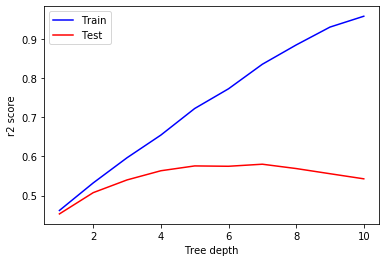

In [86]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    model = ensemble.GradientBoostingRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    roc_auc =  r2_score(y_train, y_train_preds)
    train_results.append(roc_auc)
    y_test_preds = model.predict(X_test)
    roc_auc =  r2_score(y_test, y_test_preds)
    test_results.append(roc_auc)
line1 = plt.plot(max_depths, train_results, "b", label="Train")
line2 = plt.plot(max_depths, test_results, "r", label="Test")
plt.legend()
plt.ylabel("r2 score")
plt.xlabel("Tree depth")
plt.show()


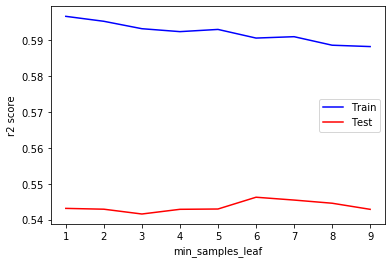

In [87]:
min_samples_leafs = list(range(1,10))
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = ensemble.GradientBoostingRegressor(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    roc_auc =  r2_score(y_train, y_train_preds)
    train_results.append(roc_auc)
    y_test_preds = model.predict(X_test)
    roc_auc =  r2_score(y_test, y_test_preds)
    test_results.append(roc_auc)
line1 = plt.plot(min_samples_leafs, train_results, "b", label="Train")
line2 = plt.plot(min_samples_leafs, test_results, "r", label="Test")
plt.legend()
plt.ylabel("r2 score")
plt.xlabel("min_samples_leaf")
plt.show()

#### Performance of the model

r2_score: 0.5926


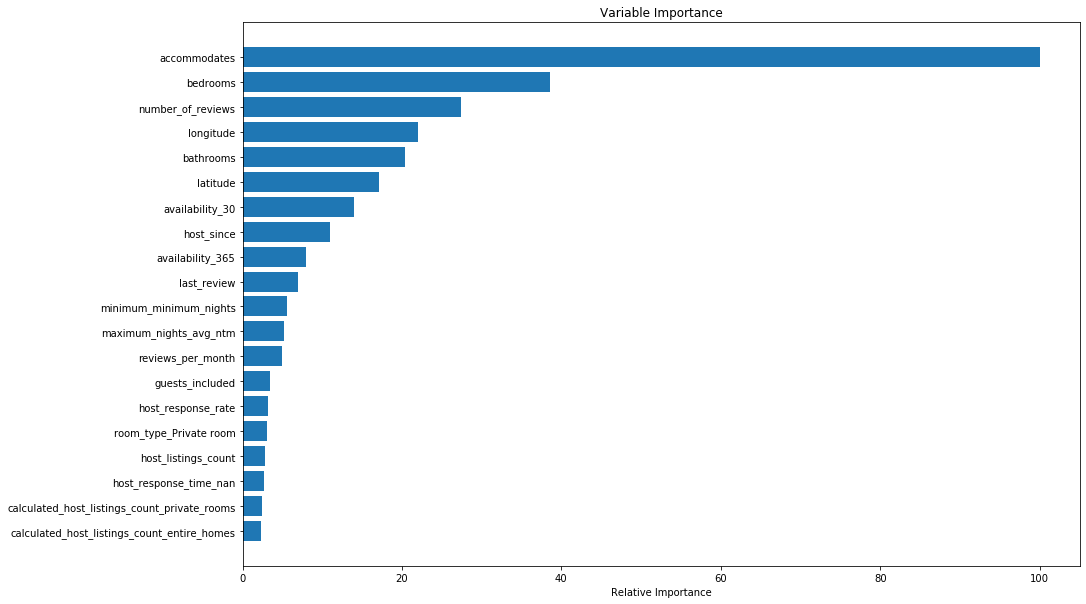

In [88]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 5, "min_samples_leaf":6}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
y_test_preds = clf.predict(X_test)
r2 = r2_score(y_test, y_test_preds)
print("r2_score: %.4f" % r2)

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[-20:].shape[0]) + 0.5
plt.figure(figsize=(15,10))
plt.barh(pos, feature_importance[sorted_idx[-20:]], align='center')
plt.yticks(pos, X.columns[sorted_idx][-20:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Comparison of the actuals of the first 200 listings in our test dataset, as well as the predictions of model.

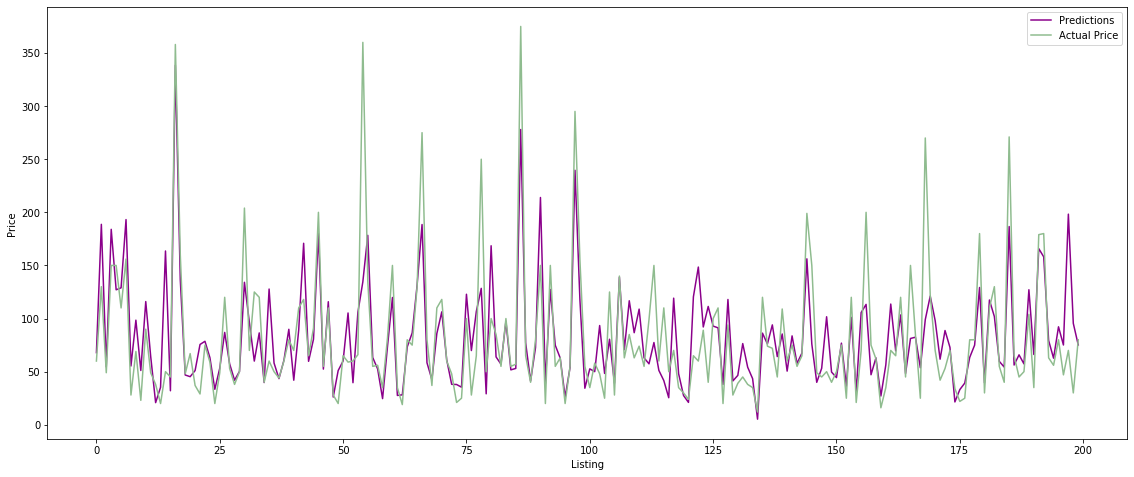

In [89]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0,0,1,1])
ax.plot(y_test_preds[0:200], label='Predictions',color="darkmagenta")
ax.plot(y_test[0:200].reset_index().drop('index',axis=1),label='Actual Price',color="darkseagreen")
ax.legend()
ax.set_ylabel('Price')
ax.set_xlabel('Listing');